In [1]:
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics.pairwise import rbf_kernel

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import *

from sklearn.feature_selection import RFE, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest

import numpy as np
import random

from sklearn.preprocessing import minmax_scale

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [3]:
X, y = make_regression(n_samples=1000, n_features=400, random_state=42)

In [4]:
"""
we will try to learn X, y

How this will work is as follows:

1.  We will stream each feature one at a time
2.  When a feature is accepted we will retrospectively assess whether it is now redundant
3.  Go back to 1 until complete

This algorithm will be based on IIC for streaming. (alpha investing...)

"""
# https://alliance.seas.upenn.edu/~datamine/wiki/index.php?title=Streamwise_feature_selection

'\nwe will try to learn X, y\n\nHow this will work is as follows:\n\n1.  We will stream each feature one at a time\n2.  When a feature is accepted we will retrospectively assess whether it is now redundant\n3.  Go back to 1 until complete\n\nThis algorithm will be based on IIC for streaming. (alpha investing...)\n\n'

In [5]:
from sklearn.linear_model import SGDRegressor, SGDClassifier

In [6]:
mod = SGDRegressor(penalty='elasticnet', random_state=42)
mod.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False)

<Container object of 400 artists>

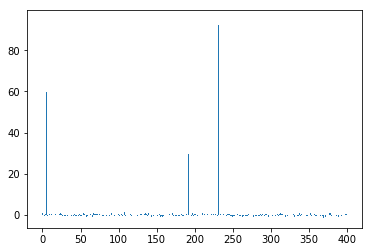

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(range(len(mod.coef_.flatten())), mod.coef_.flatten())

In [8]:
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("mse: {}".format(mse))

mse: 24.637786535216073


Make this scikit learn compatible.

In [9]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection.base import SelectorMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from dpp import sample_dpp, decompose_kernel

def dpp_sample_k(items, L, k, max_nb_iterations=1000):
    """
    Sample a list of k items from a DPP defined
    by the similarity matrix L. The algorithm
    is iterative and runs for max_nb_iterations.
    The algorithm used is from
    (Fast Determinantal Point Process Sampling with
    Application to Clustering, Byungkon Kang, NIPS 2013)
    
    
    """
    initial = np.random.choice(range(len(items)), size=k, replace=False)
    X = [False] * len(items)
    for i in initial:
        X[i] = True
    X = np.array(X)
    for i in range(max_nb_iterations):
        u = np.random.choice(np.arange(len(items))[X])
        v = np.random.choice(np.arange(len(items))[~X])
        Y = X.copy()
        Y[u] = False
        L_Y = L[Y, :]
        L_Y = L_Y[:, Y]
        try:
            L_Y_inv = np.linalg.inv(L_Y)
        except:
            pass

        c_v = L[v:v+1, :]
        c_v = c_v[:, v:v+1]
        b_v = L[Y, :]
        b_v = b_v[:, v:v+1]
        c_u = L[u:u+1, :]
        c_u = c_u[:, u:u+1]
        b_u = L[Y, :]
        b_u = b_u[:, u:u+1]

        p = min(1, c_v - np.dot(np.dot(b_v.T, L_Y_inv), b_v) /
                (c_u - np.dot(np.dot(b_u.T, L_Y_inv.T), b_u)))
        if np.random.uniform() <= p:
            X = Y[:]
            X[v] = True
    return np.array(items)[X]

class DPPSelector(BaseEstimator, SelectorMixin):
    """
    Implements a DPP feature selector to select (in unsupervised way or otherwise)
    a set of diverse features. 
    
    Parameters
    ==========
    
    *  num_feats: number of features to select (as a fraction)
    *  num_rows: number of rows to sample for DPP sampling, if set to None, then will use full data to sample. 
    
    """
    def __init__(self, n_features=10, L=None, metric=rbf_kernel):
        self.n_features = n_features
        self.L = L
        self.metric=metric
    
    def fit(self, X, y=None):
        #def dpp_feature_selection(X, L=None, metric=rbf_kernel, num_feats=0.5):
        import math
        if self.n_features == X.shape[1]:
            self.indices_ = np.ones(X.shape[1], dtype=np.bool)
            return self
        if self.L is None:
            try:
                feat_dist = squareform(self.metric(X.T), force='tovector', checks=False)
                feat_dist = squareform(feat_dist)
            except:
                feat_dist = self.metric(X.T)
                feat_dist = squareform(feat_dist)
        else:
            feat_dist = L
        
        #feat_index = dpp_sample_k(list(range(X.shape[1])), feat_dist, 
        #                          self.n_features, self.max_nb_iterations)
        feat_index = sample_dpp(decompose_kernel(feat_dist), k=self.n_features)
        #return feat_index
        dppmask = np.zeros(X.shape[1])
        dppmask[feat_index] = 1
        self.indices_ = dppmask.astype(np.bool)
        return self
    
    def _get_support_mask(self):
        check_is_fitted(self, 'indices_')
        return self.indices_

In [10]:
# pipeline example
mod = Pipeline([
    #('dpp_select', DPPSelector(n_features=400)), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])
mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))

accuracy: 24.637786535216073


In [11]:
# pipeline example
mod = Pipeline([
    ('dpp_select', DPPSelector(n_features=200)), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])
mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))

accuracy: 15941.568786350645


In [12]:
# using spectral selection (unsupervised)
# takes wayyy too long to evalute
"""
from skfeature.function.similarity_based import SPEC

mod = Pipeline([
    ('dpp_select', SelectKBest(score_func=SPEC.spec, k=200)), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])

mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))
"""

'\nfrom skfeature.function.similarity_based import SPEC\n\nmod = Pipeline([\n    (\'dpp_select\', SelectKBest(score_func=SPEC.spec, k=200)), \n    (\'lm\', SGDRegressor(penalty=\'elasticnet\', random_state=42))\n])\n\nmod.fit(X, y)\nyhat = mod.predict(X)\nmse = mean_squared_error(y, yhat)\nprint("accuracy: {}".format(mse))\n'

In [13]:
mod = Pipeline([
    ('dpp_select', PCA(n_components = 200)), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])
mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))

accuracy: 10351.430644366006


In [14]:
# takes a long time to evaluate
"""
mod = Pipeline([
    ('dpp_select', KernelPCA(n_components = 200, kernel='rbf')), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])
mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))
"""

'\nmod = Pipeline([\n    (\'dpp_select\', KernelPCA(n_components = 200, kernel=\'rbf\')), \n    (\'lm\', SGDRegressor(penalty=\'elasticnet\', random_state=42))\n])\nmod.fit(X, y)\nyhat = mod.predict(X)\nmse = mean_squared_error(y, yhat)\nprint("accuracy: {}".format(mse))\n'

In [15]:
# pipeline example
mod = Pipeline([
    ('dpp_select', SelectKBest(f_classif, k=200)), 
    ('lm', SGDRegressor(penalty='elasticnet', random_state=42))
])
mod.fit(X, y)
yhat = mod.predict(X)
mse = mean_squared_error(y, yhat)
print("accuracy: {}".format(mse))

accuracy: 19852.734165013633


c:\users\chapm\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
